# Housing Price Prediction Model

In [12]:
# First import some libraries that we know we are going to need.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Prepare the Data

In [13]:
# Read in full downloaded dataset
housing = pd.read_csv("pp-complete.csv", header = None)

The dataset is over 4GB, which makes computation time very long for this machine. To get around this problem, I am going to randomly sample from the data (without replacement) to obtain a new dataset with 100,000 rows. This is still a relatively large sample so it will still reflect the distribution of the data, without the need for using stratified sampling. A random state is going to be used to ensure the resulting dataset is reproducible.

In [14]:
# Sample from the data and save it in a new variable 
housing_sample = housing.sample(n = 100000, replace = False, random_state = 42)

We now need to filter the data to only take the columns of interest. An array y is created to store the labels (which in this case is the house prices), and a data frame X is created to store the predictor variables (property type, estate type, location). The location column must also be transformed into a binary value indicating whether the property is in London.

In [15]:
# Filter to only take columns of interest
y = housing_sample[1]
X = housing_sample[[4, 6, 11]]
# Filter location to be a boolean for london/not london
X[11] = np.where(X[11].str.contains("LONDON"), 1, 0)
# Add more meaningful column names
y.columns = "price"
X.columns = ["property.type", "estate.type", "london"]

/Users/alexcurtis/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Let's have a look at the first five rows of the data to see if it has been formatted correctly.

In [16]:
X.head()

,property.type,estate.type,london
22470060,T,F,1
22284178,D,F,0
19668643,S,F,0
3632478,S,L,0
10190356,D,F,0


Looks good! Now let's just make sure there aren't any missing values.

In [17]:
# Check if there are any missing values
X.isna().any().any()

False

This confirms that there are no missing values so all good. 
We now need to transform our predictor data, X, so that the factors in the categorical variables are all binary values. This will be essential in fitting the models later on. We can do this using Scikit-Learn's OneHotEncoder class implemented in a column tranforming pipeline.

In [18]:
# Use one-hot encoding to handle categorical variables
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define which variables to transform
cat_attribs = ["property.type", "estate.type"]

# Create pipeline
full_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_attribs),
])

# Transform data
X = full_pipeline.fit_transform(X)

We now need to split the data into training and testing data so we can evaluate the model later on. As instructed, we will do this by using pre-2017 data for training, and the rest for testing. To do this we can import datetime, and filter the data using datetime values.

In [19]:
import datetime

# Transform date column in the original sample data to datetime values
housing_sample[2] = pd.to_datetime(housing_sample[2])

# Calculate where date is pre- or post-2017 and save the indices in an array
index_train = (housing_sample[2] < datetime.datetime(2017, 1, 1))
index_test = (housing_sample[2] >= datetime.datetime(2017, 1, 1))

# Split the data using the inidices above
y_train = y[index_train]
y_test = y[index_test]
X_train = X[index_train]
X_test = X[index_test]

If we have split the data correctly, the lengths of the test plus the train data should equal the length of the original data. Check if this is true:

In [20]:
# Check that this has been done correctly 
len(y) == len(y_train) + len(y_test)

True

That means the data has been successfully split. Let's have a look at the ratio of test to train to ensure we have ample data for each.

In [21]:
len(y_test) / len(y_train)

0.16675222849675642

This seems reasonable.

## Step 2: Exploratory Data Analysis
There isn't much we can do here since all of the predictor data is categorical. We can still have a look at the distribution of the labels to see what we are trying to predict. We do this by creating a histogram.

(array([8.5608e+04, 7.1000e+01, 1.6000e+01, 7.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([9.50000000e+01, 2.34788550e+06, 4.69567600e+06, 7.04346650e+06,
        9.39125700e+06, 1.17390475e+07, 1.40868380e+07, 1.64346285e+07,
        1.87824190e+07, 2.11302095e+07, 2.34780000e+07]),
 <BarContainer object of 10 artists>)

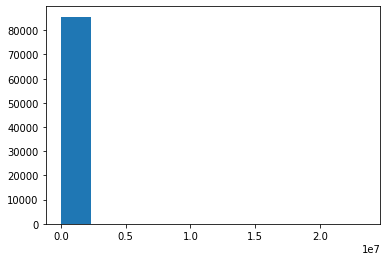

In [22]:
plt.hist(y_train)

There are clearly some very high values (around 20,000,000) that are causing the data to be heavily right-skewed. Although these values are large, there is no reason to believe they are anomalous so we cannot remove them on those grounds. This skew will be a problem when fitting the models so let's try transforming the data to see if we can get a more reasonable distribution.

(array([2.0000e+00, 1.0000e+00, 1.1000e+01, 3.0600e+02, 9.2010e+03,
        4.4181e+04, 2.9750e+04, 2.1290e+03, 1.1400e+02, 1.3000e+01]),
 array([ 4.55387689,  5.79564664,  7.03741639,  8.27918614,  9.52095588,
        10.76272563, 12.00449538, 13.24626513, 14.48803487, 15.72980462,
        16.97157437]),
 <BarContainer object of 10 artists>)

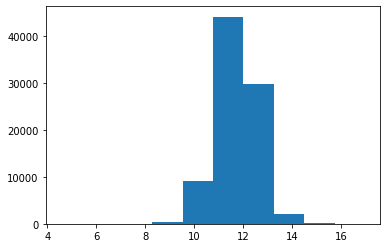

In [23]:
# Try a log transform
plt.hist(np.log(y_train))

That looks a lot better to fit models to. Let's now use log(price) to fit some models.

## Step 3: Explore Different Models

Let's look at several different types of models for predicting log house sale prices. We can evalaute these models using cross-validation (with the negative mean squared error as our scoring function) to select a model class, which we can then fine-tune.

### Model 1: Linear Regression

The first type of model we will look at is linear regression. 

In [24]:
from sklearn.linear_model import LinearRegression

# Create linear regression object
lin_reg = LinearRegression()

Evaluate this model using 10-fold cross-validation.

In [25]:
from sklearn.model_selection import cross_val_score

# Calculate cross-validation scores
scores = cross_val_score(lin_reg, X_train, np.log(y_train),
                             scoring="neg_mean_squared_error", cv=10)

# Square root the scores so they are on the same scale as the response
rmse_scores = np.sqrt(-scores)
# Output the mean of the scores
np.mean(rmse_scores)

0.7426422504631365

### Model 2: Decision Tree Regressor
We will now repeat the exact same process, this time, with a decision tree regressor.

In [26]:
from sklearn.tree import DecisionTreeRegressor

# Create decision tree object, and set random state to ensure results are reproducible
tree_reg = DecisionTreeRegressor(random_state = 42)

In [27]:
# Calculate cross-validation scores
tree_scores = cross_val_score(tree_reg, X_train, np.log(y_train),
                             scoring="neg_mean_squared_error", cv=10)

# Square root the scores so they are on the same scale as the response
tree_rmse_scores = np.sqrt(-tree_scores)
# Output the mean of the scores
np.mean(tree_rmse_scores)

0.7412977991361361

### Model 3: Random Forest Regressor
The final model we will try will be a random forest regressor. This is an ensemble method which uses decision trees so we would expect it to produce a better result that the one above (although at greater computational cost).

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Create random forest object, and set random state to ensure results are reproducible
forest_reg = RandomForestRegressor(random_state = 42)

In [29]:
# Calculate cross-validation scores
forest_scores = cross_val_score(forest_reg, X_train, np.log(y_train),
                             scoring="neg_mean_squared_error", cv=10)

# Square root the scores so they are on the same scale as the response
forest_rmse_scores = np.sqrt(-forest_scores)
# Output the mean of the scores
np.mean(forest_rmse_scores)

0.7412977954008283

The best model (i.e. the one with the lowest RMSE score) is the random forest regressor, so we will continue with that and fine-tune the parameters. Since there wasn't a big difference between this model and the decision tree model, we could also perhaps have gone with that since it saves on computation time. However, let's assume for now that computation time isn't an issue and continue with the random forest model.

## Step 4: Fine-tuning the model
Let's now continue with the random forest regressor and fine-tune the hyperparameters to find the best model. We can do this using grid search, which can be implemented using Scikit-Learn's GridSearchCV class which searches for the hyperparameters that minimise the cross-validation score. Again, we will use the negative mean squared error as our scoring function, although now we will use only 5-fold cross-validation, otherwise the computation time is too large.

In [30]:
from sklearn.model_selection import GridSearchCV

# Create a grid of hyperparamters to search over
parameters = [{'n_estimators': [5, 10, 20, 30, 40], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [5, 10, 20, 30, 40], 'max_features': [2, 4, 6, 8]},]

# Create random forest object, setting random state for reproducibilty
forest_reg = RandomForestRegressor(random_state = 42)
    
# Create grid search object, with specified hyperparameters to search
grid_search = GridSearchCV(forest_reg, parameters, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
    
# Run the grid search algorithm with the training data
grid_search.fit(X_train, np.log(y_train))

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [5, 10, 20, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [5, 10, 20, 30, 40]}],
             return_train_score=True, scoring='neg_mean_squared_error')

We can now see what the optimal hyperparameters are.

In [31]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 40}

These hyperparameters are at the top of the specified range so let's do another search to see if we can further improve our model.

In [32]:
# Create a finer grid with larger hyperparameters to search over
parameters = [{'bootstrap': [False], 'n_estimators': [38, 39, 40, 41, 42, 43], 'max_features': [7, 8]},]

# Create grid search object
grid_search = GridSearchCV(forest_reg, parameters, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
    
# Run the grid search
grid_search.fit(X_train, np.log(y_train))

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [False], 'max_features': [7, 8],
                          'n_estimators': [38, 39, 40, 41, 42, 43]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Again let's see what the optimal hyperparaters were.

In [33]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 38}

Interestingly, the max_features optimum has gone down. This perhaps suggests there isn't much improvement to be had around these values and so the output values are somewhat volatile. Either way, we can continue with these hyperparamters to evaluate our model.

## Step 5: Evaluate and Present the Model
It is now time to evaluate the model using the test data. As we have been doing throughout the process, we will be using root mean squared error as the metric on which to evaluate the model. This is chosen as it is easy to compare on the scale of the prediction, so we can get meaningful results.

In [34]:
from sklearn.metrics import mean_squared_error

# Create the model with the optimum hyperparameters
best_model = RandomForestRegressor(random_state = 42, bootstrap = False, max_features = 8, n_estimators = 38)
# Fit the model using the training data
best_model.fit(X_train, np.log(y_train))
    
# Make predictions using the test data
predictions = best_model.predict(X_test)
    
# Calculate the RMSE, by using the test data labels
mse = mean_squared_error(np.log(y_test), predictions)
rmse = np.sqrt(mse)
rmse

0.9761307099058814

This is currently meaningless, since we have no scale with which to compare it to. The predictions were log(price), so let's calculate the mean of this value.

In [35]:
np.mean(np.log(y))

11.821622701443603

The mean of log(price) is over 11. That means the RMSE score of our model is pretty good. We can also calculate it as a fraction of the mean.

In [36]:
rmse / np.mean(np.log(y_test))

0.07909549056437751

The RMSE of the final model is less than 8% of the mean of the predictor values. That means it must have a pretty good predicitve power.

We can also have a look at what features were most important for prediction in the final model.

In [45]:
# Define which attributes to look at (i.e. 'london' and the one-hot encoded ones)
extra_attribs = ["london", "estate.type"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = extra_attribs + cat_one_hot_attribs

# Extract feature importances from the best model
feature_importances = best_model.feature_importances_
# Output the results in order of importance
sorted(zip(feature_importances, attributes), reverse=True)

[(0.7448844054730149, 'london'),
 (0.1284416371095474, 'O'),
 (0.06442131831867201, 'T'),
 (0.026443714896735467, 'D'),
 (0.025742554692928292, 'S'),
 (0.009952849512996992, 'F'),
 (0.0, 'estate.type')]

It looks like the 'london' binary variable was by far the most important predictor, at over 74%. The next best were the property type predictors (summing to roughly 25%), while estate type only contributed to less than 1%.